# Credit Scoring Model Using Scikit-Learn
# Repo from https://github.com/rorodata/credit-scoring-demo

### Credit Scoring
A credit score is a numerical expression based on a level analysis of a person's credit files, to represent the creditworthiness of an individual. Traditionally, a credit score was primarily based on credit report information typically sourced from credit bureaus. However, with the proliferation of data science, institutions of any size can develop their own credit scoring system and sharpen them for applications to their target markets

### Scikit-learn
Scikit-learn  is an Open source machine learning library Python, and features various classification, regression and clustering algorithms, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

Scikit-learn prides itself on the following aspects
- Simple and efficient tools for data mining and data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license


### Lending Club Dataset

Lending Club is a US peer-to-peer lending company, headquartered in San Francisco, California. Lending Club is the world's largest peer-to-peer lending platform. The company states that $15.98 billion in loans had been originated through its platform up to 31 December 2015.

We shall use their loan data for this exercise. Their public datasets can be accessed from https://www.lendingclub.com/info/download-data.action

## Setups

In [ ]:
# !pip install pandas numpy matplotlib sklearn sklearn_pandas
# !git clone https://github.com/cstorm125/kbank_alchemists
# !mv kbank_alchemists/* .
# !ls

## Let’s Get Started

In [11]:
import pandas as pd, numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV

import sklearn
from sklearn_pandas import DataFrameMapper

import matplotlib.pyplot as plt

DATA_PATH = 'data/loans/'

### Step1
Let’s first load the loans data. For your conviniebce, we have made this available as exp-lending-club-data.csv on rorocloud. We shall use a pandas dataframe to read this data into, as pandas is an excellent tool for data preparation and analysis.

In [13]:
# IN_DATAFILE='https://s3.amazonaws.com/rorodata-datasets/lending-club-data.csv'
# loans = pd.read_csv(IN_DATAFILE, infer_datetime_format = True)
loans = pd.read_csv(f'{DATA_PATH}lending-club-data.csv')
print(loans.columns,loans.shape)
loans.head()

/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


### Step 2:  
The dataframe loans has 68 columns of data. However, we shall work with only those columns that we find relevant for our model. We have picked 18 columns for this exercise, these have been identified in the list named features. We want to use these features to predict the column bad_loan (1 for bad loan, 0 for otherwise)- hence, this is a binary classification problem
To create this data subset in pandas is a cinch
> clean_data=loans[features+[response]].dropna()

In [14]:
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
           ]
response='bad_loans'

In [15]:
clean_data=loans[features+[response]].dropna()

### Step 3:  
Now that we have the data set that we need for modelling, we need to apply some preprocessing steps to get the data into a form that scikit-learn algorithms can use. In almost all cases, scikit-learn algorithms have the interface model.fit(X,y), where X and y are numerical matrices representing the features and the target respectively.
We will do only one simple preprocessing steps for this tutorial, i.e. convert categorical data into one-hot encoded format. We use the scikit proprocessing model called LabelBinarizer() on only the Categorial columns.
At the end of this step, we have a dataset (X,y)  where X and y are numpy arrays  and all columns are numerical values (with categorical variables being one-hot encoded)

In [16]:
numerical_cols=['sub_grade_num', 'short_emp', 'emp_length_num','dti', 'payment_inc_ratio', 'delinq_2yrs', \
                'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none', 'open_acc',\
                'pub_rec', 'pub_rec_zero','revol_util']

categorical_cols=['grade', 'home_ownership', 'purpose']

mapper = DataFrameMapper([
('grade',sklearn.preprocessing.LabelBinarizer()),
('home_ownership', sklearn.preprocessing.LabelBinarizer()),
('purpose', sklearn.preprocessing.LabelBinarizer()),
        
    ])

X1=mapper.fit_transform(clean_data)


X2=np.array(clean_data[numerical_cols])


X = np.hstack((X1,X2)) #Combines X1 and X2 side by side, i.e. stacks them horizontally
y=np.array(clean_data['bad_loans'])



### Step 4
The first step in build and testing models is to do a split of train-test data, so that we have unbiased estimates of the model’s error. We keep aside a third of the data for testing purposes, and use 2/3rds for training. This is accomplished very simply in Scikit-learn as follows

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

### Step 5
The actual model building in scikit is tremendously simplified, and follows the same pattern as below


```
model=scikit_model_class()       initializes  a model of class scikit_model_class
model.fit(X_train, y_train)      fits a model on the training data set
model.score(X_test, y_test)      evaluates the performance of the model on the test data set
```

#### Fit a Logistic Regression model

In [18]:
log_lm = LogisticRegression()
log_lm.fit(X_train, y_train)
log_lm.score(X_test, y_test)

/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8117969889495933

#### Fit a Gradient Boosting model

In [19]:
grd = GradientBoostingClassifier(n_estimators=100)
grd.fit(X_train, y_train)
grd.score(X_test, y_test)

0.8114261699339942

### Missing Step 4.5

Does 80% sound great to you? If so, you might need to revise the models you have done so far. Before you determining the performance of any model, here are some useful things to consider:

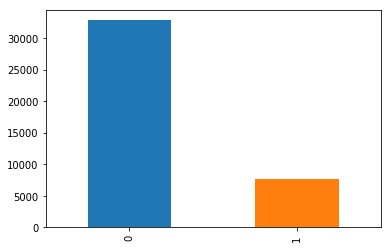

In [28]:
pd.Series(y_test).value_counts().plot(kind='bar')

In [29]:
baseline_acc = np.mean(y_test==0)
print(f'Baseline accuracy when predicting most common class: {baseline_acc}')

Baseline accuracy when predicting most common class: 0.8111542359892215


Does this mean the model is useless? Not necessarily

In [23]:
probs = grd.predict_proba(X_test)
probs

array([[0.89218786, 0.10781214],
       [0.79484719, 0.20515281],
       [0.75481723, 0.24518277],
       ...,
       [0.790453  , 0.209547  ],
       [0.71648812, 0.28351188],
       [0.69221375, 0.30778625]])

In [37]:
nb_predicted = np.sum(probs[:,1])
nb_actual = np.sum(y_test)
print(f'Number of predicted default: {nb_predicted}')
print(f'Number of actual default: {nb_actual}')
print(f'Mean Absolute Percentage Error: {np.mean(abs(nb_predicted-nb_actual)) / min(nb_predicted,nb_actual)}')

Number of predicted default: 7625.025698745521
Number of actual default: 7639
Mean Absolute Percentage Error: 0.0018326890697270308
